## Correlation Power Analysis (CPA) - Data Acquisition

Correlation Power Analysis (CPA) is a variant of power side channel analysis that collects many power traces while the device under test (DUT) is performing a cryptographic operation. The attacker selects an attack piont where an intermediate value is calculated in the device. The intermeadiate value should be a function of known data (e.g plaintext) and a small portion of the key.
The attacker uses all possible values of the key portion to calculate the possible values of the intermediate. A power model (e.g. Hamming weight or distance) is used to calculated values propotional to the power consumtion of the device while it calculates the intermediate. These values are called the hypothetical power.
The real power traces collected are statistically correlated with hypothetical power to find the key portion most likley used in the crypto operation.

In this project, you will apply CPA on a AES-128 FPGA implementation (DUT). A setup is provided to send test vectors to the DUT, collect the traces for you using a power probe and ADC. Later in the project, you will take the traces and run the CPA analysis software to find the secret key used in the algorithm.
The goal is to be familiar with the process of CPA and the settings involved.

Step 1: Choose the intermediate value
--------------------------------------
We choose an intermediate variable that is processed in the algorithm. The intermediate value is calculated as *f(d, k)*
where *d* is a known non-constant value that can be derived from known data (e.g. plaintext) and *k* is small part of the key. The image below shows the block diagram of the AES-128 that we attack in this project. This an FPGA hardware implementation.

The hypothetical power is calculated as: <br/>
H(i,j) = HD(SBOX(CT(i) ), SBOX(key_guess(j) xor PT(i+1) ))

The attack is performed on one key byte at a time.
    
![alt text](aes128.png "Logo Title Text 1")


Step 2: Power measurement
-------------------------
Measure the power consumption of the  crypto device while it encrypts D data blocks.
We need to know the value *d* that corresponds to each data block. These values can be written as a vector **d** = [d<sub>1</sub>, d<sub>2</sub>, ..., d<sub>D</sub>].
The power consumption signal for a single encryption/decryption operation is called a trace.
A trace is vector that records instantaneous power consumption for a period that inculdes the time when the intermediate value is processed.
The trace generated while encrypting/decrypting data block *i* consists of *T* samples and can be viewed as a vector **t**<sub>i</sub> = [t<sub>i,1</sub>, t<sub>i,2</sub>,... , t<sub>i,T</sub>].
The traces are stacked in a matrix **T** with dimensions *D x T* where each row *i* is a trace generated while encrypting/decrypting block *i*.


The setup provided to you is composed of the following components:

1. **FOBOS3 control board**: Receives test vectors from the SCA workstation and forwords them to the DUT (design-under-test). Once the DUT starts processing a test vector (running the crypto algorithm), the control board collects the instantaneous power consumption of the DUT using a current probe. The control board also generates a clock signal for the DUT and controls the trigger signal (used to trigger ADC/oscilloscope to collect a trace)

2. **DUT board**: Here we instantiate the crypto core (a.k.a victim. AES-128 in this case) which we want to attack. We need to measure the power consumption of this board. We have a Digilent Nexys 3 board (uses a Xilinx Spartan6 FPGA) as a DUT board.

3. **DPA workstation** : This is the machine where all capture/analysis scripts can be run. To collect traces, you run a script that connects to the control board via network, send test vectors one at a time, and receives results (ciphertext) and traces back from the control board. Results and traces are stored in files in the DPA workstation for furtuher analysis.

   ### Excercice
  
  #### Input files:
1- On the top this notebook, click File-> Open. Go to fobsoworkspace/aes. What is the value of the first block we use as input (plaintext)? How many bytes are in the block and why?

  Run the following cell (Shift + Enter) to import libraries needed for the capture software and configure input and output files.

In [110]:
# import libs
import os
import sys
import shutil
import fobos.pynqctrl
from fobos.fobosctrl import FOBOSCtrl
import fobos.projmgr
import fobos.nexys3dut
import numpy as np
#######################################################
# connection to ctrl board
IP = '192.168.10.99'
PORT = 9995

# File names and locations
WORKSPACE = "./fobosworkspace"
PROJECT_NAME = "aes"
DIN_FILE_NAME = "dinFile.txt"
CIPHER_FILE = "ciphertext.txt"
PLAIN_FILE = "plaintext.txt"
TRACE_FILE  = "powerTraces.npy"
DUT_BIT_FILE = "half_duplex_dut.bit"

In the code below, set the  DUT clock to 1 MHz and ADC sampling frequency to 50 Msps.

2- How many samples will be collected every DUT clock cycle? <br/>
3- If you want to collect the entire AES encryption process for one test vector (one block), what  is the number of samples you need to collect. (Hint : This implemetation needs first 4 clock cycles to load data + 10 clock cycles to finish the AES rounds). Using the number of samples you calculated, set the SAMPLES_PER_TRACE in the script.

We need to collect 10000 traces for this attack. The TRACE_NUM parameter is configured accordingly.

After you finish the configuration, run the following cell.

In [112]:
DUT_CLk = 1                       # in MHz
SAMPLING_FREQ =  50                  # in M Sample ps
SAMPLES_PER_TRACE =  700              # number of sample in one trace
#do not change below this line.
TRACE_NUM = 10000
ADC_GAIN = 40                      # amplification of ADC input signal
OUT_LEN = 16                       # number of output bytes from AES-128

Run this cell to checkout and connect to the harware. This locks the hardware while you are  using it. Once you finish the hardware is released to allow others to access it.
You should see a message saying 'Acquired hardware lock'. If the hardware is used it will wait for some time until hardware is available. If this does not work, please try again after few minutes.

Once the hardware is accessed, the script first applies the configuration parameters you configured previously to the control board. It also specifies files where the test vectors are read and where the results and traces will be saved. <br/>
It then sends the test vectors one at a time to the contorl board, receives the ciphertext and traces back and stores them in files.

In [113]:
# connect to hardware and lock it ######################################
ctrl = fobos.pynqctrl.PYNQCtrl(IP, PORT)
# Apply config to ctrl board ###########################################
ctrl.setDUTClk(DUT_CLk)
ctrl.setDUTInterface(FOBOSCtrl.INTERFACE_4BIT)
ctrl.setOutLen(OUT_LEN)
ctrl.setTriggerMode(FOBOSCtrl.TRG_FULL)
# configure trace sampling #############################################
ctrl.setSamplingFrequency(SAMPLING_FREQ)
ctrl.setADCGain(ADC_GAIN)
ctrl.setSamplesPerTrace(SAMPLES_PER_TRACE)
# Configure project directories#########################################
pm = fobos.projmgr.ProjectManager()
pm.setWorkSpaceDir(WORKSPACE)
pm.setProjName(PROJECT_NAME)
projDir = pm.getProjDir()
# program DUT ##########################################################
dut = fobos.nexys3dut.Nexys3DUT()
bitFile = os.path.join(projDir, DUT_BIT_FILE)
dut.setBitFile(bitFile)
dut.program()
# prepare i/o files ####################################################
tvFileName = os.path.join(projDir, DIN_FILE_NAME)
plainFileName = os.path.join(projDir, PLAIN_FILE)
tvFile = open(tvFileName, "r")
captureDir = pm.getCaptureDir()
cipherFileName = os.path.join(captureDir, CIPHER_FILE)
cipherFile = open(cipherFileName, "w")
traceFileName = os.path.join(captureDir, TRACE_FILE)
traceFile = open(traceFileName, "a+b")
shutil.copy(tvFileName, captureDir)
shutil.copy(plainFileName, captureDir)
# Get traces############################################################
print('Processing test vectors ...')
traceNum = 0
while traceNum < TRACE_NUM:
    data = tvFile.readline()
    status, result, trace = ctrl.processData2(data, OUT_LEN)
    cipherFile.write(result + "\n")
    np.save(traceFile, trace)
    if traceNum % 100 == 0:
        sys.stdout.write(f'Progress: {traceNum/TRACE_NUM*100:.2f} %\r')
        sys.stdout.flush()
    traceNum += 1
    
ctrl.disconnect() # release control board.

Acquired hardware lock
outlen=16
Programming device using the following commands:
djtgcfg init -d Nexys3
djtgcfg prog -d Nexys3 -i 0 -f ./fobosworkspace/aes/half_duplex_dut.bit
b'Programming device. Do not touch your board. This may take a few minutes...\nProgramming succeeded.\n'
Successfully created new capture directory at ./fobosworkspace/aes/capture/attempt-9
Processing test vectors ...
Disconnect requested. Bye!
Released hardware lock.


(0, 'Disconnect requested. Bye!')

Now, plot the first 100 traces collected using the following code. Graph must be shown in your final report.

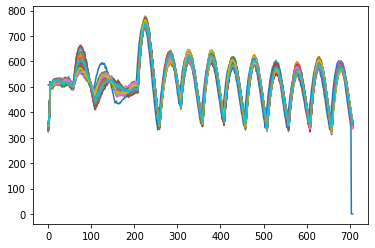

In [115]:
import matplotlib.pyplot as plt
traceFile.seek(0)
for i in range(0,100):
    trace = np.load(traceFile)
    plt.plot(trace)
    
traceFile.close()
cipherFile.close()
tvFile.close()

4- How many peaks are in the trace? Are they related to the number of AES-128 rounds (expect some smaller peaks for data loading)?

5- Explain why traces differ (Give at least two reasons). 

6- Look in the fobosworkspace/aes/capture. Where are traces and ciphertext are stored? How many bytes are in each ciphertext block? Why?

Please note that the trace file includes 10000 traces similar to this and each of them is stored as a row vector of samples.



By the end of this notebook you have the traces stored in the T matrix. We need this in the next step to recover the secret key used in the AES cipher!
